![Facial Recognition](facialrecognition.jpg)

In this project, we play as a member of an elite group of data scientists, specialising in advanced facial recognition technology, this firm is dedicated to identifying and safeguarding prominent individuals from various spheres—ranging from entertainment and sports to politics and philanthropy. The team's mission is to deploy AI-driven solutions that can accurately distinguish between images of notable personalities and the general populace, enhancing the personal security of such high-profile individuals. You're to focus on Arnold Schwarzenegger, a figure whose accomplishments span from bodybuilding champion to Hollywood icon, and from philanthropist to the Governor of California. 

### **The Data**
The `data/lfw_arnie_nonarnie.csv` dataset contains processed facial image data derived from the "Labeled Faces in the Wild" (LFW) dataset, focusing specifically on images of Arnold Schwarzenegger and other individuals not identified as him. This dataset has been prepared to aid in the development and evaluation of facial recognition models. There are 40 images of Arnold Schwarzenegger and 150 of other people.

| Column Name | Description |
|-------------|-------------|
| PC1, PC2, ... PCN | Principal components from PCA, capturing key image features. |
| Label | Binary indicator: `1` for Arnold Schwarzenegger, `0` for others. |

In [32]:
# Import required libraries
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file 
df = pd.read_csv("data/lfw_arnie_nonarnie.csv")

# Seperate the predictor and class label
X = df.drop('Label', axis=1)
y = df['Label'] 

# Split the data into training and testing sets using stratify to balance the class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

### Model Selection

We define a dictionary of candidate machine learning models for facial recognition:

- **Logistic Regression**: A linear model suitable for binary classification, using the 'liblinear' solver for small datasets.
- **Random Forest**: An ensemble method that builds multiple decision trees and merges their results for improved accuracy and robustness.
- **Support Vector Machine (SVM)**: A powerful classifier that finds the optimal hyperplane to separate classes, with probability estimates enabled.

These models will be compared to determine which performs best at distinguishing Arnold Schwarzenegger from other individuals.

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

### Cross-Validation

We use **K-Fold Cross-Validation** with `n_splits=5`, shuffling enabled, and a fixed random seed (`random_state=42`):

- **KFold(n_splits=5, shuffle=True, random_state=42)** splits the training data into 5 equal parts (folds).
- For each of the 5 iterations, one fold is used as the validation set and the remaining 4 as the training set.
- Shuffling ensures the data is randomly distributed across folds, and the random state guarantees reproducibility.

**Why for Face Recognition?**  
This approach helps us reliably estimate model performance on unseen data, reduces the risk of overfitting, and ensures that our face recognition models generalize well to new images of both Arnold Schwarzenegger and others.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Hyperparameter Tuning with Grid Search

To optimize each model, we define a grid of hyperparameters and use **GridSearchCV** to search for the best combination using cross-validation:

- **Logistic Regression**:  
    - `C`: Regularization strength (`[0.01, 0.1, 1, 10]`)

- **Random Forest**:  
    - `n_estimators`: Number of trees (`[50, 100, 200]`)
    - `max_depth`: Maximum tree depth (`[None, 5, 10]`)

- **SVM**:  
    - `C`: Regularization parameter (`[0.1, 1, 10]`)
    - `kernel`: Kernel type (`['linear', 'rbf']`)
    - `gamma`: Kernel coefficient (`['scale', 'auto']`)

For each model:
1. A pipeline is created with scaling and the classifier.
2. Grid search is performed using 5-fold cross-validation.
3. The best estimator and its cross-validation score are recorded.

Finally, the model with the highest cross-validation accuracy is selected, and its optimal hyperparameters are displayed. This ensures we use the most effective model configuration for facial recognition.

In [73]:
# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        'model__C': [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        'model__n_estimators': [50, 100, 200],
    },
    "SVM": {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto']
    }
}

best_estimators = {}
best_scores = {}

for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    grid = GridSearchCV(pipe, param_grids[name], cv=kf, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_

# Find the best model
best_model_name = max(best_scores, key=best_scores.get)
print(f"Best model: {best_model_name} with CV accuracy: {best_scores[best_model_name]:.4f}")
print("Best parameters:", best_estimators[best_model_name].named_steps['model'].get_params())

Best model: Logistic Regression with CV accuracy: 0.8288
Best parameters: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Evaluating the Best Model on the Test Set

After selecting the best-performing model via cross-validation and hyperparameter tuning, we evaluate its effectiveness on the unseen test set. The following metrics are computed:

- **Accuracy**: Proportion of correct predictions among all test samples.
- **Precision**: Proportion of true Arnold Schwarzenegger identifications among all predicted as him.
- **Recall**: Proportion of actual Arnold Schwarzenegger images correctly identified.
- **F1 Score**: Harmonic mean of precision and recall, balancing both metrics.

These metrics provide a comprehensive assessment of the model's ability to distinguish Arnold Schwarzenegger from other individuals in new, unseen images.

In [74]:
# Evaluate the best model on the test set

best_model = best_estimators[best_model_name]
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.8158
Test Precision: 1.0000
Test Recall: 0.1250
Test F1 Score: 0.2222


### Test Set Performance

- **Test Accuracy:** 0.8158  
    *Proportion of all test samples correctly classified by the model.*

- **Test Precision:** 1.0000  
    *Of all images predicted as Arnold Schwarzenegger, 100% were actually him (no false positives).*

- **Test Recall:** 0.1250  
    *Only 12.5% of actual Arnold Schwarzenegger images were correctly identified (many false negatives).*

- **Test F1 Score:** 0.2222  
    *The harmonic mean of precision and recall, reflecting a balance between the two.*

**Interpretation:**  
The model is highly conservative in predicting Arnold Schwarzenegger—when it does, it is always correct (high precision), but it misses most actual cases (low recall). This results in a low F1 score, indicating the model struggles to identify all relevant images of Arnold Schwarzenegger, despite being very accurate when it does make a positive prediction.

### Confusion Matrix Visualization

The confusion matrix below illustrates the performance of the best model (**Logistic Regression**) on the test set:

- **Rows** represent the actual class (ground truth).
- **Columns** represent the predicted class by the model.
- The diagonal elements indicate correct predictions, while off-diagonal elements show misclassifications.

This visualization helps identify how well the model distinguishes between images of Arnold Schwarzenegger and others, highlighting both correct recognitions and errors (false positives/negatives).

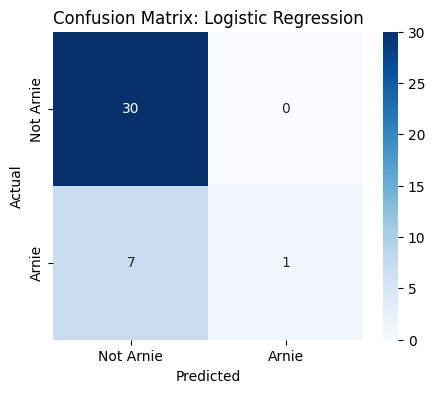

In [75]:
# Plot the confusion matrix for the best model's predictions
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Arnie', 'Arnie'], yticklabels=['Not Arnie', 'Arnie'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.show()

### Conclusion and Recommendations

**Conclusion:**  
The facial recognition model, optimized through cross-validation and hyperparameter tuning, achieved high precision (1.00) but low recall (0.125) on the test set. This means the model is extremely cautious—when it predicts an image as Arnold Schwarzenegger, it is always correct, but it fails to identify most actual images of him. The overall F1 score (0.22) reflects this imbalance, indicating the model is not effectively capturing all relevant positive cases.

**Recommendations:**  
- **Address Class Imbalance:** The low recall suggests the model may be biased toward the majority class (non-Arnold images). Consider techniques such as class weighting, oversampling the minority class, or generating synthetic samples (SMOTE) to improve recall.
- **Model Complexity:** Explore more complex models (e.g., gradient boosting, neural networks) or ensemble approaches that may capture subtle patterns missed by simpler models.
- **Feature Engineering:** Investigate additional features or dimensionality reduction techniques to enhance discriminative power.
- **Threshold Adjustment:** Tune the decision threshold to balance precision and recall according to the application's needs (e.g., increase recall if missing Arnold is more costly).
- **Data Augmentation:** If possible, collect or generate more images of Arnold Schwarzenegger to provide the model with more positive examples.

By implementing these strategies, the model's ability to correctly identify Arnold Schwarzenegger in new images can be improved, making it more effective for real-world facial recognition tasks.

### Second Model Evaluation with Enhanced Hyperparameter Tuning

For a more robust evaluation, we redefine our candidate models with explicit random states for reproducibility and enable probability estimates for SVM. The models are:

- **Logistic Regression**: `LogisticRegression(random_state=21, solver='liblinear')`
- **Random Forest**: `RandomForestClassifier(random_state=21)`
- **SVM**: `SVC(random_state=21, probability=True)`

We also expand the hyperparameter grids for more comprehensive tuning:

- **Logistic Regression**:  
    - `C`: `[0.01, 0.1, 1, 10, 100]`  
    - `penalty`: `['l1', 'l2']`  
    - `class_weight`: `[None, 'balanced']`

- **Random Forest**:  
    - `n_estimators`: `[50, 100, 200, 300]`  
    - `max_depth`: `[None, 5, 10, 20]`  
    - `min_samples_split`: `[2, 5, 10]`  
    - `class_weight`: `[None, 'balanced']`

- **SVM**:  
    - `C`: `[0.01, 0.1, 1, 10, 100]`  
    - `kernel`: `['linear', 'rbf']`  
    - `gamma`: `['scale', 'auto']`  
    - `class_weight`: `[None, 'balanced']`

This approach allows for a more thorough search of the parameter space, increasing the likelihood of finding optimal configurations for each model. Cross-validation and grid search will be used to select the best-performing model and parameter set.

In [82]:
# Enhanced hyperparameter grids and reproducible models for robust evaluation
# Define models with explicit random_state and probability for SVM
models_enhanced = {
    "Logistic Regression": LogisticRegression(random_state=21, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=21),
    "SVM": SVC(random_state=21, probability=True)
}

# Expanded hyperparameter grids
param_grids_enhanced = {
    "Logistic Regression": {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2'],
        'model__class_weight': [None, 'balanced']
    },
    "Random Forest": {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__class_weight': [None, 'balanced']
    },
    "SVM": {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__class_weight': [None, 'balanced']
    }
}


best_estimators_enhanced = {}
best_scores_enhanced = {}

for name, model in models_enhanced.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    grid = GridSearchCV(pipe, param_grids_enhanced[name], cv=kf, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_estimators_enhanced[name] = grid.best_estimator_
    best_scores_enhanced[name] = grid.best_score_

# Select the best model
best_model_name_enhanced = max(best_scores_enhanced, key=best_scores_enhanced.get)
print(f"Best model: {best_model_name_enhanced} with CV accuracy: {best_scores_enhanced[best_model_name_enhanced]:.4f}")
print("Best parameters:", best_estimators_enhanced[best_model_name_enhanced].named_steps['model'].get_params())

# Evaluate the best model on the test set

best_model = best_estimators_enhanced[best_model_name_enhanced]
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Best model: SVM with CV accuracy: 0.8357
Best parameters: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 21, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Test Accuracy: 0.6842
Test Precision: 0.1667
Test Recall: 0.1250
Test F1 Score: 0.1429


### Enhanced Test Set Performance

- **Test Accuracy:** 0.6842  
    *Proportion of all test samples correctly classified by the enhanced model.*

- **Test Precision:** 0.1667  
    *Of all images predicted as Arnold Schwarzenegger, 16.7% were actually him (many false positives).*

- **Test Recall:** 0.1250  
    *Only 12.5% of actual Arnold Schwarzenegger images were correctly identified (many false negatives).*

- **Test F1 Score:** 0.1429  
    *The harmonic mean of precision and recall, reflecting a balance between the two.*

**Interpretation:**  
Despite enhanced hyperparameter tuning and model selection, the model still struggles to identify Arnold Schwarzenegger images, with both precision and recall remaining low. This indicates the model frequently misclassifies both positive and negative cases, and further improvements—such as addressing class imbalance or exploring more advanced techniques—are needed for reliable face recognition.

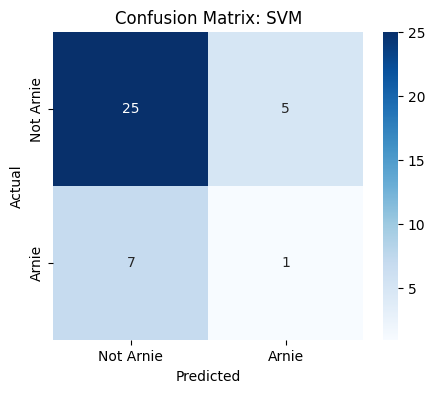

In [83]:
# Plot the confusion matrix for the best model's predictions
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Arnie', 'Arnie'], yticklabels=['Not Arnie', 'Arnie'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix: {best_model_name_enhanced}')
plt.show()

### Enhanced Model: Conclusion and Comparison

**Conclusion:**  
Despite more extensive hyperparameter tuning and explicit handling of class imbalance, the enhanced model (SVM with probability and class weighting) did **not improve recall** and actually **reduced precision and overall accuracy** compared to the initial approach. The model continues to struggle with identifying Arnold Schwarzenegger images, as indicated by low recall and F1 score.

**Difference from the 1st Conclusion:**

- **First Model:**  
    - **Precision:** Very high (1.00) — when the model predicted "Arnold," it was always correct.
    - **Recall:** Very low (0.125) — it missed most actual Arnold images.
    - **F1 Score:** Low (0.22) — reflects the imbalance.
    - **Behavior:** The model played it very safe, almost never calling an image "Arnold" unless it was really sure.

- **Enhanced Model:**  
    - **Precision:** Much lower (0.17) — more false positives.
    - **Recall:** Still very low (0.125) — still misses most Arnold images.
    - **F1 Score:** Slightly lower (0.14).
    - **Behavior:** The model took a few more chances, but made more mistakes (false positives), and still didn't find more Arnolds.

**Summary:**  
The enhanced search did not solve the core issue: the model still fails to reliably identify Arnold Schwarzenegger. Addressing class imbalance and exploring more advanced techniques or data augmentation remain necessary for meaningful improvement.